In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from PIL import Image
from matplotlib.ticker import FuncFormatter


In [2]:
def plot_liq(df_day, hour, ax, show = True):
    df_day = df_day[df_day['hour'] == hour].sort_values(by='priceMid')
    x = df_day['priceMid'].values
    w = np.diff(x).min() * 0.8 
    
    ax.bar(x, df_day['usd_token0'], width =w, label = 'USDC', color = "cornflowerblue")
    ax.bar(x, df_day['usd_token1'], width =w, label = 'USDT', color = "mediumaquamarine")
    ax.axvline(1, color = 'black')
    ax.axvline(df_day.query('usd_token0 > 0')['priceMid'].values[0], color = 'grey', linestyle = '--', label = 'active tick')
    # plt.bar(x, df_day['usd_total'], width =w)
    ax.set_xlabel('USDC price')
    ax.set_ylabel('tick liquiditiy ($)')
    ax.legend(frameon = False, bbox_to_anchor= (0.62,-0.1), ncols = 3)

In [4]:
df = pd.read_parquet('./hourly_liquidity_full.parquet')

In [5]:
d = df.copy()
d["hour"] = pd.to_datetime(d["hour"])

hours = np.array(sorted(d["hour"].unique()))

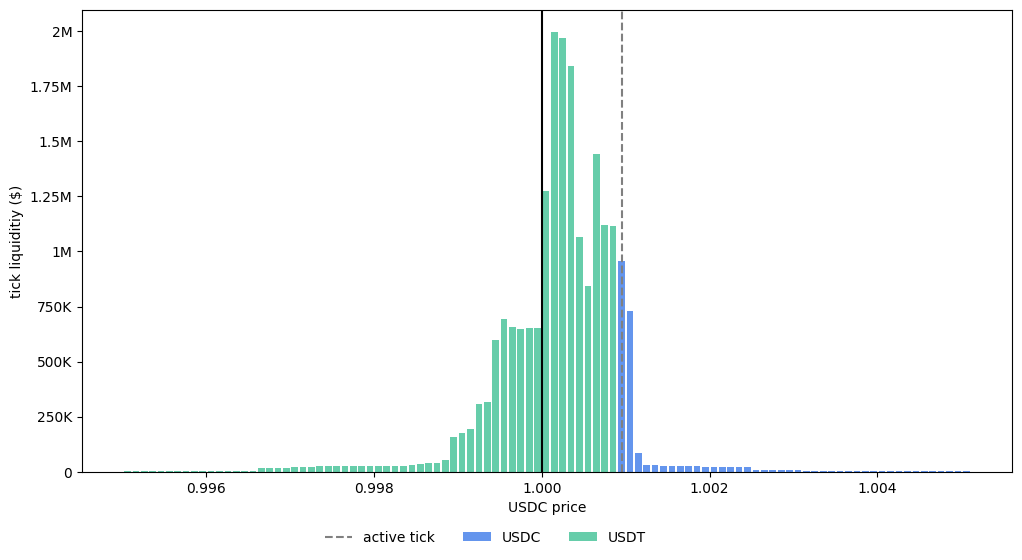

In [6]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
plot_liq(df, hours[-1], ax)
def human_format(x, pos=None):
    x = float(x)
    absx = abs(x)
    if absx >= 1_000_000:
        val = x / 1_000_000
        return f"{val:g}M" if val % 1 else f"{int(val)}M"
    if absx >= 1_000:
        val = x / 1_000
        return f"{val:g}K" if val % 1 else f"{int(val)}K"
    return f"{x:g}"
ax.yaxis.set_major_formatter(FuncFormatter(human_format))

plt.savefig('liquidity_cliff.png', dpi = 300, transparent = True, bbox_inches = 'tight')

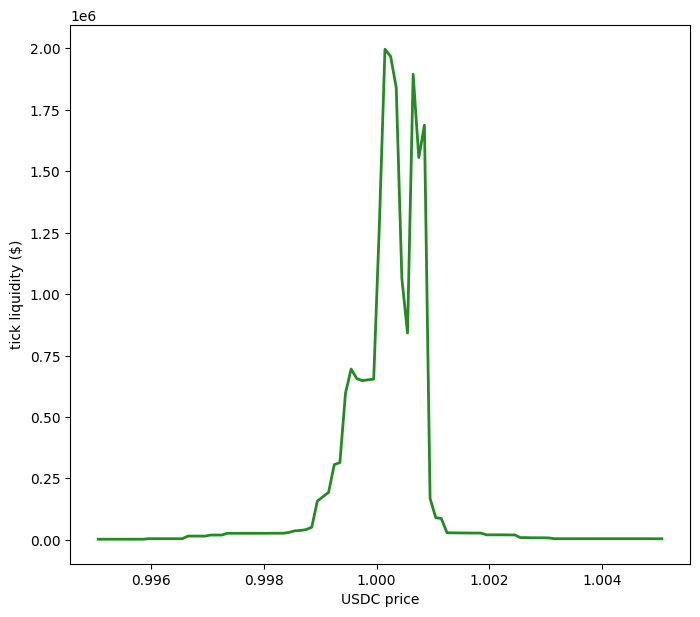

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
fig.patch.set_alpha(0)
ax.set_facecolor((0, 0, 0, 0))
plotdf = df[df['hour'] == dt.datetime(2026,1,27,4, tzinfo= dt.timezone.utc)]
plt.plot(plotdf['priceMid'].values, plotdf['usd_total'].values, lw = 2, color = "forestgreen")
plt.xlabel('USDC price')
plt.ylabel('tick liquidity ($)')
plt.savefig('uniswap_liquidity_2026-01-27.png', dpi = 300, bbox_inches = 'tight', transparent=True)

In [123]:
# --- figure ---
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)
fig.subplots_adjust(bottom=0.18)
fig.patch.set_alpha(0)          # transparent figure background
ax.set_facecolor("none")        # transparent axes background

stop = 400

df_ = df[df["hour"].between(
    dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc),
    dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc) + dt.timedelta(hours=stop-1)
)]
x_min, x_max = df_["priceMid"].min(), df_["priceMid"].max()
y_max = (df_[["usd_token0", "usd_token1"]].sum(axis=1)).max()

# give a little padding
x_pad = 0.002 if np.isfinite(x_min) else 0.0
ax_xmin, ax_xmax = x_min - x_pad, x_max + x_pad
ax_ymin, ax_ymax = 0.0, 1.05 * y_max if np.isfinite(y_max) else 1.0


def _render_frame(k):
    ax.clear()
    ax.set_facecolor("none")

    hour = dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc) + dt.timedelta(hours=k)
    df_day = df[df["hour"] == hour].sort_values(by="priceMid")

    if df_day.empty:
        # still render a blank frame with consistent axes
        ax.set_xlim(ax_xmin, ax_xmax)
        ax.set_ylim(ax_ymin, ax_ymax)
        ax.set_xlabel("USDC price")
        ax.set_ylabel("tick liquidity ($)")
        ax.set_title(f"{hour.isoformat()} (no data)")
        return

    x = df_day["priceMid"].to_numpy()

    # robust bar width (avoid errors when only 1 tick)
    if len(x) >= 2:
        w = 0.8 * np.min(np.diff(x))
    else:
        w = 0.0001  # fallback width

    ax.bar(x, df_day["usd_token0"].to_numpy(), width=w, label="USDC", color="cornflowerblue")
    ax.bar(x, df_day["usd_token1"].to_numpy(), width=w, label="USDT", color="mediumaquamarine")

    ax.axvline(1.0, color="black", linewidth=1)

    active = df_day.loc[df_day["usd_token0"] > 0, "priceMid"]
    if not active.empty:
        ax.axvline(active.iloc[0], color="grey", linestyle="--", label="active tick")

    ax.set_xlim(ax_xmin, ax_xmax)
    ax.set_ylim(ax_ymin, ax_ymax)

    ax.set_xlabel("USDC price")
    ax.set_ylabel("tick liquidity ($)")
    ax.set_title(hour.isoformat())

    ax.legend(frameon=False, bbox_to_anchor=(0.65, -0.1), ncols=3)


def frame_images():
    for k in range(stop):
        _render_frame(k)

        # IMPORTANT: draw AFTER plotting, then capture buffer
        fig.canvas.draw()
        rgba = np.asarray(fig.canvas.buffer_rgba())  # (H, W, 4)
        img = Image.fromarray(rgba, mode="RGBA")

        # Convert to palette GIF while keeping transparency:
        pal = img.convert("P", palette=Image.Palette.ADAPTIVE)
        transparent_index = pal.getpixel((0, 0))  # assumes background is uniform/transparent
        pal.info["transparency"] = transparent_index
        pal.info["disposal"] = 2  # restore to background between frames

        yield pal


# --- save GIF ---
it = frame_images()
first = next(it)
first.save(
    "liq_curve.gif",
    save_all=True,
    append_images=it,
    duration= 60,
    loop=0,
    optimize=True,        
    disposal=2,
    transparency=first.info.get("transparency", 0),
)

plt.close(fig)